In [1]:
##Setting up the python environment
import pandas as pd
import os 
import re
from collections import Counter
import numpy as np
import math
import matplotlib.pyplot as plt
import string
%matplotlib inline 
import textwrap

##Setting up BQ API
from google.cloud import bigquery

# pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


##Setting up Google sdk environment
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/jupyter/.config/gcloud/application_default_credentials.json'
## Connect to the right GCP project
os.environ['GCLOUD_PROJECT'] = 'som-nero-egyang-starr' 
%load_ext google.cloud.bigquery
client=bigquery.Client()

project_id = "som-rit-phi-starr-prod"
# dataset_id = "starr_omop_cdm5_deid_1pcent_latest"
dataset_id = "starr_omop_cdm5_deid_latest"
work_project_id = 'som-nero-egyang-starr' 
work_dataset_id = 'ilies_explore'

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


/opt/conda/lib/python3.7/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [5]:
# fold_num = 1
# query="""
# (SELECT a.* EXCEPT (PAD), 1 AS label
# FROM `{work_project_id}.{work_dataset_id}.Cases_FM_temp` a
# JOIN `{work_project_id}.{work_dataset_id}.person_ids_cases_sequence_fold_{fold_num}` b
# ON a.person_id = b.person_id)
# UNION ALL
# (SELECT a.* EXCEPT (PAD), 0 AS label
# FROM `{work_project_id}.{work_dataset_id}.Controls_FM_temp` a
# JOIN `{work_project_id}.{work_dataset_id}.person_ids_controls_sequence_fold_{fold_num}` b
# ON a.person_id = b.person_id)
# """.format_map({
#                 'project_id': project_id,
#                 'dataset_id': dataset_id,
#                 'work_project_id': work_project_id,
#                 'work_dataset_id': work_dataset_id,
#                 'fold_num': fold_num})
# df = client.query(query).to_dataframe()
# df
# df.to_csv("data_{fold_num}.csv".format_map({'fold_num': fold_num}), index=False, header=True)

In [2]:
fold_num = 1
query="""
SELECT a.* EXCEPT (PAD), 1 AS label
FROM `{work_project_id}.{work_dataset_id}.Cases_FM_temp_nom` a
UNION ALL
SELECT a.* EXCEPT (PAD), 0 AS label
FROM `{work_project_id}.{work_dataset_id}.Controls_FM_temp_nom` a
""".format_map({
                'project_id': project_id,
                'dataset_id': dataset_id,
                'work_project_id': work_project_id,
                'work_dataset_id': work_dataset_id,
                'fold_num': fold_num})
df = client.query(query).to_dataframe()
df
df.to_csv("data_nom_{fold_num}.csv".format_map({'fold_num': fold_num}), index=False, header=True)

In [3]:
# fold_num = 1
# query="""
# (SELECT a.* EXCEPT (PAD), 1 AS label
# FROM `{work_project_id}.{work_dataset_id}.Cases_FM_temp` a)
# UNION ALL
# (SELECT a.* EXCEPT (PAD), 0 AS label
# FROM `{work_project_id}.{work_dataset_id}.Controls_FM_temp` a)
# """.format_map({
#                 'project_id': project_id,
#                 'dataset_id': dataset_id,
#                 'work_project_id': work_project_id,
#                 'work_dataset_id': work_dataset_id,
#                 'fold_num': fold_num})
# df = client.query(query).to_dataframe()
# df
# # df.to_csv("data_{fold_num}.csv".format_map({'fold_num': fold_num}), index=False, header=True)

In [4]:
df = pd.read_csv("data_nom_{fold_num}.csv".format_map({'fold_num': fold_num}))
df.head()

,person_id,Age,Female,Race,CVA,CAD,HF,HTN,Diab,HLD,BMI,Smoking_status,nomogram_score,label
0,31082837,50,0.0,Asian,1,0,0,0,0,0,24.354975,Ever,12,1
1,30411169,50,0.0,Asian,1,1,0,1,0,0,26.692955,Ever,15,1
2,30847162,50,0.0,Black,0,1,0,1,0,0,56.387307,Ever,21,1
3,30244509,50,1.0,Caucasian,0,0,0,0,0,1,35.479352,Ever,21,1
4,30695061,50,0.0,Caucasian,0,0,0,0,0,0,24.080282,Ever,24,1


In [5]:
df = df.dropna()
df = df.drop("person_id",axis = 1)

In [8]:
df

,Age,Female,Race,CVA,CAD,HF,HTN,Diab,HLD,BMI,Smoking_status,nomogram_score,label
0,50,0.0,Asian,1,0,0,0,0,0,24.354975,Ever,12,1
1,50,0.0,Asian,1,1,0,1,0,0,26.692955,Ever,15,1
2,50,0.0,Black,0,1,0,1,0,0,56.387307,Ever,21,1
3,50,1.0,Caucasian,0,0,0,0,0,1,35.479352,Ever,21,1
4,50,0.0,Caucasian,0,0,0,0,0,0,24.080282,Ever,24,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20322,91,1.0,Caucasian,1,1,1,1,0,1,22.271932,Current,67,0
20323,91,1.0,Caucasian,1,1,1,1,0,1,18.086073,Current,67,0
20324,91,1.0,Caucasian,1,1,1,1,0,1,17.858444,Current,67,0
20325,91,1.0,Caucasian,1,1,1,1,1,1,22.546278,Current,71,0


In [9]:
sum(df['label'])/len(df)*100

17.05731731337404

In [10]:
df["Female"] = df["Female"].astype("category")
df["Race"] = df["Race"].astype("category")
df["CVA"] = df["CVA"].astype("category")
df["CAD"] = df["CAD"].astype("category")
df["HF"] = df["HF"].astype("category")
df["HTN"] = df["HTN"].astype("category")
df["Diab"] = df["Diab"].astype("category")
df["HLD"] = df["HLD"].astype("category")
df["Smoking_status"] = df["Smoking_status"].astype("category")

In [11]:
df

,Age,Female,Race,CVA,CAD,HF,HTN,Diab,HLD,BMI,Smoking_status,nomogram_score,label
0,50,0.0,Asian,1,0,0,0,0,0,24.354975,Ever,12,1
1,50,0.0,Asian,1,1,0,1,0,0,26.692955,Ever,15,1
2,50,0.0,Black,0,1,0,1,0,0,56.387307,Ever,21,1
3,50,1.0,Caucasian,0,0,0,0,0,1,35.479352,Ever,21,1
4,50,0.0,Caucasian,0,0,0,0,0,0,24.080282,Ever,24,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20322,91,1.0,Caucasian,1,1,1,1,0,1,22.271932,Current,67,0
20323,91,1.0,Caucasian,1,1,1,1,0,1,18.086073,Current,67,0
20324,91,1.0,Caucasian,1,1,1,1,0,1,17.858444,Current,67,0
20325,91,1.0,Caucasian,1,1,1,1,1,1,22.546278,Current,71,0


In [12]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df["Race"])
list(le.classes_)
df["Race"] = le.transform(df["Race"])

In [13]:
le = preprocessing.LabelEncoder()
le.fit(df["Smoking_status"])
list(le.classes_)
df["Smoking_status"] = le.transform(df["Smoking_status"])

In [14]:
import pandas as pd
import numpy as np
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [15]:
df

,Age,Female,Race,CVA,CAD,HF,HTN,Diab,HLD,BMI,Smoking_status,nomogram_score,label
0,50,0.0,0,1,0,0,0,0,0,24.354975,1,12,1
1,50,0.0,0,1,1,0,1,0,0,26.692955,1,15,1
2,50,0.0,1,0,1,0,1,0,0,56.387307,1,21,1
3,50,1.0,2,0,0,0,0,0,1,35.479352,1,21,1
4,50,0.0,2,0,0,0,0,0,0,24.080282,1,24,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20322,91,1.0,2,1,1,1,1,0,1,22.271932,0,67,0
20323,91,1.0,2,1,1,1,1,0,1,18.086073,0,67,0
20324,91,1.0,2,1,1,1,1,0,1,17.858444,0,67,0
20325,91,1.0,2,1,1,1,1,1,1,22.546278,0,71,0


In [17]:
X = df.drop("label",axis = 1) 
y = df.label

In [18]:
X

,Age,Female,Race,CVA,CAD,HF,HTN,Diab,HLD,BMI,Smoking_status
0,79,0.0,2,1,0,0,1,0,0,26.506465,1
1,86,1.0,2,0,0,0,1,0,0,27.968241,1
2,58,0.0,2,0,0,0,1,0,0,25.280733,0
3,69,1.0,0,0,0,0,1,0,1,22.399953,1
4,80,1.0,2,0,1,1,1,0,0,30.675407,0
...,...,...,...,...,...,...,...,...,...,...,...
6925,91,0.0,2,1,1,0,1,0,1,25.341716,0
6926,91,0.0,2,1,1,1,1,0,0,24.271708,1
6927,91,0.0,2,0,1,0,1,0,0,24.158733,1
6928,91,1.0,1,1,1,1,1,0,1,22.056966,1


In [19]:
# sum(df.label)/len(df.label)*100

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [21]:
logistic_regression = LogisticRegression()

In [22]:
logistic_regression.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [23]:
y_pred = logistic_regression.predict_proba(X_test)[:,1]
y_pred

array([0.17418078, 0.04085832, 0.27913401, ..., 0.14052568, 0.40899024,
       0.26214783])

In [24]:
np.mean(y_pred)

0.1002132849340004

In [25]:
np.mean(y_test)

0.09474292316580012

In [26]:
# logistic_regression.importance

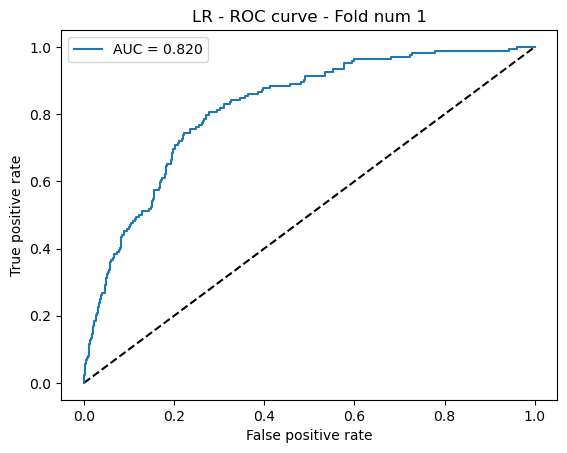

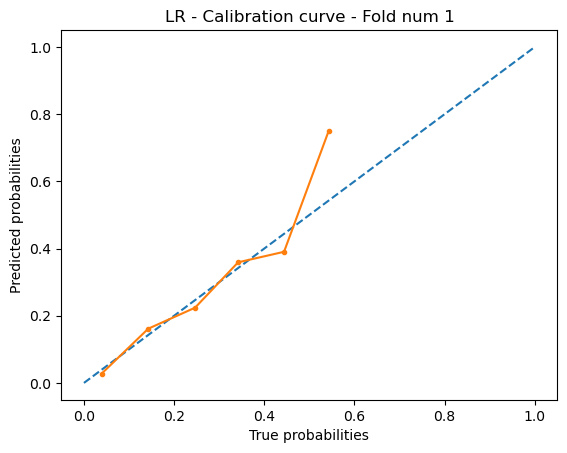

In [27]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve


fpr, tpr, thresholds = roc_curve(y_test,y_pred)
auc = auc(fpr, tpr)
auc

fold_num_print = 'Fold_num_1'
fold_title = 'Fold num 1'

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('LR - ROC curve - ' + str(fold_title))
plt.legend(loc='best')
plt.savefig('PAD_LR_auc_curve_'+str(fold_num_print)+'.jpeg')
plt.show()

# reliability diagram
fop, mpv = calibration_curve(y_test, y_pred, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.xlabel('True probabilities')
plt.ylabel('Predicted probabilities')
plt.title('LR - Calibration curve - '+ str(fold_title))
plt.savefig('PAD_LR_calibration_'+fold_num_print+'.jpeg')
plt.show()


In [33]:
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
optimal_threshold = thresholds[ix]
print("optimal_threshold = ", optimal_threshold)

cm=confusion_matrix(y_test, y_pred>optimal_threshold)
TP = cm[0][0]
FN = cm[0][1]
FP = cm[1][0]
TN = cm[1][1]
# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)

cm,TP,TN,FP,FN,auc,TNR,TPR

print("AUC = ", auc)
print("Specificity = ", TNR)
print("Sensitivity = ", TPR)

import numpy as np
import scipy.stats
from scipy import stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def compute_midrank_weight(x, sample_weight):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    cumulative_weight = np.cumsum(sample_weight[J])
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = cumulative_weight[i:j].mean()
        i = j
    T2 = np.empty(N, dtype=np.float)
    T2[J] = T
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count, sample_weight):
    if sample_weight is None:
        return fastDeLong_no_weights(predictions_sorted_transposed, label_1_count)
    else:
        return fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight)


def fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank_weight(positive_examples[r, :], sample_weight[:m])
        ty[r, :] = compute_midrank_weight(negative_examples[r, :], sample_weight[m:])
        tz[r, :] = compute_midrank_weight(predictions_sorted_transposed[r, :], sample_weight)
    total_positive_weights = sample_weight[:m].sum()
    total_negative_weights = sample_weight[m:].sum()
    pair_weights = np.dot(sample_weight[:m, np.newaxis], sample_weight[np.newaxis, m:])
    total_pair_weights = pair_weights.sum()
    aucs = (sample_weight[:m]*(tz[:, :m] - tx)).sum(axis=1) / total_pair_weights
    v01 = (tz[:, :m] - tx[:, :]) / total_negative_weights
    v10 = 1. - (tz[:, m:] - ty[:, :]) / total_positive_weights
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def fastDeLong_no_weights(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating
              Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth, sample_weight):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    if sample_weight is None:
        ordered_sample_weight = None
    else:
        ordered_sample_weight = sample_weight[order]

    return order, label_1_count, ordered_sample_weight


def delong_roc_variance(ground_truth, predictions, sample_weight=None):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(
        ground_truth, sample_weight)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


alpha = .95
# y_pred = np.array([0.21, 0.32, 0.63, 0.35, 0.92, 0.79, 0.82, 0.99, 0.04])
y_true = y_test

auc_delong, auc_cov = delong_roc_variance(
    y_true,
    y_pred)

auc_std = np.sqrt(auc_cov)
lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

ci = stats.norm.ppf(
    lower_upper_q,
    loc=auc_delong,
    scale=auc_std)

ci[ci > 1] = 1

print('AUC:', auc_delong)
# print('AUC COV:', auc_cov)
print('95% AUC CI:', ci)

d = {'auc': auc, 'specificity': TNR, 'sensitivity': TPR}
df = pd.DataFrame(data=d, index = [0], dtype=np.float64)
df.to_csv('auc_specificity_sensitivity_fold1.csv', index=False)

optimal_threshold =  0.10639475610108579
AUC =  0.8197036437499028
Specificity =  0.7926829268292683
Sensitivity =  0.7287811104020421
AUC: 0.8197036437499027
95% AUC CI: [0.78795949 0.8514478 ]


In [34]:
aucs = []
specificitys = []
sensitivitys = []

for i in range(5):
    df = pd.read_csv('auc_specificity_sensitivity_fold' + str(i+1) + '.csv')  
    aucs.append(float(df['auc']))
    specificitys.append(float(df['specificity']))
    sensitivitys.append(float(df['sensitivity']))
    

In [35]:
["{:.3f}".format(v) for v in aucs]

['0.820', '0.769', '0.790', '0.803', '0.789']

In [36]:
["{:.3f}".format(v) for v in specificitys] 

['0.793', '0.691', '0.801', '0.743', '0.722']

In [37]:
["{:.3f}".format(v) for v in sensitivitys] 

['0.729', '0.727', '0.658', '0.732', '0.721']

In [38]:
np.mean(aucs)
"{:.3f}".format(np.mean(aucs))

'0.794'

In [39]:
np.mean(specificitys)
"{:.3f}".format(np.mean(specificitys))

'0.750'

In [40]:
np.mean(sensitivitys)
"{:.3f}".format(np.mean(sensitivitys))

'0.713'

In [ ]:
fold_num = 1
query="""
(SELECT a.* EXCEPT (PAD), 1 AS label
FROM `{work_project_id}.{work_dataset_id}.Cases_FM_temp` a
JOIN `{work_project_id}.{work_dataset_id}.person_ids_cases_sequence_fold_{fold_num}` b
ON a.person_id = b.person_id)
UNION ALL
(SELECT a.* EXCEPT (PAD), 0 AS label
FROM `{work_project_id}.{work_dataset_id}.Controls_FM_temp` a
JOIN `{work_project_id}.{work_dataset_id}.person_ids_controls_sequence_fold_{fold_num}` b
ON a.person_id = b.person_id)
""".format_map({
                'project_id': project_id,
                'dataset_id': dataset_id,
                'work_project_id': work_project_id,
                'work_dataset_id': work_dataset_id,
                'fold_num': fold_num})
df = client.query(query).to_dataframe()
df
df.to_csv("data_{fold_num}.csv".format_map({'fold_num': fold_num}), index=False, header=True)

# Nomogram scores

## Cases

In [65]:
query="""
CREATE OR REPLACE TABLE `{work_project_id}.{work_dataset_id}.Cases_FM_temp_nom` AS
SELECT *, 
(CASE 
WHEN 45 <= Age AND Age <= 49 THEN 0
WHEN 50 <= Age AND Age <= 54 THEN 1
WHEN 55 <= Age AND Age <= 59 THEN 2
WHEN 60 <= Age AND Age <= 64 THEN 3
WHEN 65 <= Age AND Age <= 69 THEN 4
WHEN 70 <= Age AND Age <= 74 THEN 5
WHEN 75 <= Age AND Age <= 79 THEN 6
WHEN 80 <= Age AND Age <= 84 THEN 7
WHEN 85 <= Age AND Age <= 89 THEN 8
WHEN 90 <= Age AND Age <= 94 THEN 9
WHEN 95 <= Age AND Age <= 99 THEN 10
WHEN 100 <= Age THEN 11
END) AS age_score,
(CASE 
WHEN Female = 0 THEN 0
WHEN Female = 1 THEN 4
ELSE 0
END) AS sex_score,
(CASE 
WHEN Race IN ('Black', 'Other') THEN 16
WHEN Race IN ('Caucasian', 'Hispanic') THEN 15
WHEN Race IN ('Asian') THEN 0
ELSE 15
END) AS race_score,
(CASE WHEN Diab = 1 THEN 4
ELSE 0
END) AS diab_score,
(CASE 
WHEN BMI <= 23 THEN 10
WHEN 23 <= BMI AND BMI <= 24 THEN 9
WHEN 24 <= BMI AND BMI <= 26 THEN 8
WHEN 26 <= BMI AND BMI <= 27 THEN 7
WHEN 27 <= BMI AND BMI <= 29 THEN 6
WHEN 29 <= BMI AND BMI <= 31 THEN 5
WHEN 31 <= BMI AND BMI <= 32 THEN 4
WHEN 32 <= BMI AND BMI <= 34 THEN 3
WHEN 34 <= BMI AND BMI <= 35 THEN 2
WHEN 35 <= BMI AND BMI <= 38 THEN 1
WHEN 38 <= BMI  THEN 0
ELSE 6
END) AS bmi_score,
(CASE WHEN HTN = 1 THEN 2
ELSE 0
END) AS htn_score,
(CASE WHEN Smoking_status = 'Current' THEN 13
ELSE 0
END) AS smoking_score,
(CASE WHEN CAD = 1 THEN 2
ELSE 0
END) AS cad_score,
(CASE WHEN CVA = 1 THEN 3
ELSE 0
END) AS cva_score,
(CASE WHEN HF = 1 THEN 9
ELSE 0
END) AS hf_score,
FROM `{work_project_id}.{work_dataset_id}.Cases_FM_temp` 
""".format_map({
                'project_id': project_id,
                'dataset_id': dataset_id,
                'work_project_id': work_project_id,
                'work_dataset_id': work_dataset_id,
                'fold_num': fold_num})
df = client.query(query).to_dataframe()
df

query="""
CREATE OR REPLACE TABLE `{work_project_id}.{work_dataset_id}.Cases_FM_temp_nom` AS
SELECT *, (age_score + sex_score + race_score + diab_score + bmi_score + htn_score + smoking_score + cad_score + cva_score + hf_score) 
AS nomogram_score
FROM `{work_project_id}.{work_dataset_id}.Cases_FM_temp_nom` 
""".format_map({
                'project_id': project_id,
                'dataset_id': dataset_id,
                'work_project_id': work_project_id,
                'work_dataset_id': work_dataset_id,
                'fold_num': fold_num})
df = client.query(query).to_dataframe()
df

query="""
CREATE OR REPLACE TABLE `{work_project_id}.{work_dataset_id}.Cases_FM_temp_nom` AS
SELECT person_id, PAD, Age, Female, Race, CVA, CAD, HF, HTN, Diab, HLD, BMI, Smoking_status, nomogram_score
FROM `{work_project_id}.{work_dataset_id}.Cases_FM_temp_nom` 
""".format_map({
                'project_id': project_id,
                'dataset_id': dataset_id,
                'work_project_id': work_project_id,
                'work_dataset_id': work_dataset_id,
                'fold_num': fold_num})
df = client.query(query).to_dataframe()
df

""


In [66]:
query="""
SELECT *
FROM `{work_project_id}.{work_dataset_id}.Cases_FM_temp_nom` 
""".format_map({
                'project_id': project_id,
                'dataset_id': dataset_id,
                'work_project_id': work_project_id,
                'work_dataset_id': work_dataset_id,
                'fold_num': fold_num})
df = client.query(query).to_dataframe()
df

,person_id,PAD,Age,Female,Race,CVA,CAD,HF,HTN,Diab,HLD,BMI,Smoking_status,nomogram_score
0,31082837,1,50,0,Asian,1,0,0,0,0,0,24.354975,Ever,12
1,30411169,1,50,0,Asian,1,1,0,1,0,0,26.692955,Ever,15
2,30847162,1,50,0,Black,0,1,0,1,0,0,56.387307,Ever,21
3,30244509,1,50,1,Caucasian,0,0,0,0,0,1,35.479352,Ever,21
4,30695061,1,50,0,Caucasian,0,0,0,0,0,0,24.080282,Ever,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3459,32576807,1,91,0,Caucasian,0,1,1,1,1,0,21.852969,Current,64
3460,32237999,1,91,0,Caucasian,1,1,1,1,1,1,24.387717,Current,65
3461,30929238,1,91,1,Caucasian,1,1,1,1,0,1,22.908250,Current,67
3462,30789596,1,91,1,Caucasian,1,1,1,1,0,1,22.168696,Current,67


## Controls

In [63]:
query="""
CREATE OR REPLACE TABLE `{work_project_id}.{work_dataset_id}.Controls_FM_temp_nom` AS
SELECT *, 
(CASE 
WHEN 45 <= Age AND Age <= 49 THEN 0
WHEN 50 <= Age AND Age <= 54 THEN 1
WHEN 55 <= Age AND Age <= 59 THEN 2
WHEN 60 <= Age AND Age <= 64 THEN 3
WHEN 65 <= Age AND Age <= 69 THEN 4
WHEN 70 <= Age AND Age <= 74 THEN 5
WHEN 75 <= Age AND Age <= 79 THEN 6
WHEN 80 <= Age AND Age <= 84 THEN 7
WHEN 85 <= Age AND Age <= 89 THEN 8
WHEN 90 <= Age AND Age <= 94 THEN 9
WHEN 95 <= Age AND Age <= 99 THEN 10
WHEN 100 <= Age THEN 11
END) AS age_score,
(CASE 
WHEN Female = 0 THEN 0
WHEN Female = 1 THEN 4
ELSE 0
END) AS sex_score,
(CASE 
WHEN Race IN ('Black', 'Other') THEN 16
WHEN Race IN ('Caucasian', 'Hispanic') THEN 15
WHEN Race IN ('Asian') THEN 0
ELSE 15
END) AS race_score,
(CASE WHEN Diab = 1 THEN 4
ELSE 0
END) AS diab_score,
(CASE 
WHEN BMI <= 23 THEN 10
WHEN 23 <= BMI AND BMI <= 24 THEN 9
WHEN 24 <= BMI AND BMI <= 26 THEN 8
WHEN 26 <= BMI AND BMI <= 27 THEN 7
WHEN 27 <= BMI AND BMI <= 29 THEN 6
WHEN 29 <= BMI AND BMI <= 31 THEN 5
WHEN 31 <= BMI AND BMI <= 32 THEN 4
WHEN 32 <= BMI AND BMI <= 34 THEN 3
WHEN 34 <= BMI AND BMI <= 35 THEN 2
WHEN 35 <= BMI AND BMI <= 38 THEN 1
WHEN 38 <= BMI  THEN 0
ELSE 6
END) AS bmi_score,
(CASE WHEN HTN = 1 THEN 2
ELSE 0
END) AS htn_score,
(CASE WHEN Smoking_status = 'Current' THEN 13
ELSE 0
END) AS smoking_score,
(CASE WHEN CAD = 1 THEN 2
ELSE 0
END) AS cad_score,
(CASE WHEN CVA = 1 THEN 3
ELSE 0
END) AS cva_score,
(CASE WHEN HF = 1 THEN 9
ELSE 0
END) AS hf_score,
FROM `{work_project_id}.{work_dataset_id}.Controls_FM_temp` 
""".format_map({
                'project_id': project_id,
                'dataset_id': dataset_id,
                'work_project_id': work_project_id,
                'work_dataset_id': work_dataset_id,
                'fold_num': fold_num})
df = client.query(query).to_dataframe()
df

query="""
CREATE OR REPLACE TABLE `{work_project_id}.{work_dataset_id}.Controls_FM_temp_nom` AS
SELECT *, (age_score + sex_score + race_score + diab_score + bmi_score + htn_score + smoking_score + cad_score + cva_score + hf_score) 
AS nomogram_score
FROM `{work_project_id}.{work_dataset_id}.Controls_FM_temp_nom` 
""".format_map({
                'project_id': project_id,
                'dataset_id': dataset_id,
                'work_project_id': work_project_id,
                'work_dataset_id': work_dataset_id,
                'fold_num': fold_num})
df = client.query(query).to_dataframe()
df

query="""
CREATE OR REPLACE TABLE `{work_project_id}.{work_dataset_id}.Controls_FM_temp_nom` AS
SELECT person_id, PAD, Age, Female, Race, CVA, CAD, HF, HTN, Diab, HLD, BMI, Smoking_status, nomogram_score
FROM `{work_project_id}.{work_dataset_id}.Controls_FM_temp_nom` 
""".format_map({
                'project_id': project_id,
                'dataset_id': dataset_id,
                'work_project_id': work_project_id,
                'work_dataset_id': work_dataset_id,
                'fold_num': fold_num})
df = client.query(query).to_dataframe()
df

""


In [64]:
query="""
SELECT *
FROM `{work_project_id}.{work_dataset_id}.Controls_FM_temp_nom` 
""".format_map({
                'project_id': project_id,
                'dataset_id': dataset_id,
                'work_project_id': work_project_id,
                'work_dataset_id': work_dataset_id,
                'fold_num': fold_num})
df = client.query(query).to_dataframe()
df

,person_id,PAD,Age,Female,Race,CVA,CAD,HF,HTN,Diab,HLD,BMI,Smoking_status,nomogram_score
0,32292719,0,50,0.0,Asian,0,0,0,1,0,0,34.106077,Ever,5
1,32158471,0,50,0.0,Asian,0,0,0,0,0,0,30.906818,Ever,6
2,30907133,0,50,1.0,Asian,0,0,0,1,0,0,41.222908,Ever,7
3,30951211,0,50,0.0,Asian,0,0,0,0,0,1,28.650075,Ever,7
4,30144162,0,50,0.0,Asian,0,0,0,0,0,0,28.931597,Ever,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16858,31320792,0,91,1.0,Caucasian,1,1,1,1,0,1,22.271932,Current,67
16859,31732671,0,91,1.0,Caucasian,1,1,1,1,0,1,18.086073,Current,67
16860,30787339,0,91,1.0,Caucasian,1,1,1,1,0,1,17.858444,Current,67
16861,31454813,0,91,1.0,Caucasian,1,1,1,1,1,1,22.546278,Current,71
